### Importing libraries

In [84]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
import dateutil
import statsmodels
import statsmodels.api as sm
import itertools
from collections import defaultdict
from sklearn import metrics,preprocessing  
from sklearn.model_selection import train_test_split,RepeatedKFold,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,perceptron,Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import neighbors
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report, average_precision_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
sns.set()
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Ingestion

In [3]:
df=pd.read_csv('data/final_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 21 columns):
INDEMNITY_PAID_TO_DATE_USD_AM    525 non-null float64
EXPENSE_PAID_TO_DATE_USD         525 non-null float64
TYPE_NM                          525 non-null object
FATAL_INJURY_IN                  525 non-null object
HAS_INJURY_DETAILS               525 non-null bool
INJURY_BODY_PART_DS              525 non-null object
INJURY_CATEGORY_DS               525 non-null object
INJURY_DS                        525 non-null object
INJURY_SEVERITY_DS               522 non-null object
MAIN_CAUSE_DS                    524 non-null object
SUB_CAUSE_DS                     524 non-null object
INSURED_NM                       523 non-null object
CLAIM_TYPE                       525 non-null object
LOSS_DT                          525 non-null object
POLICY_EFF_DT                    523 non-null object
POLICY_EXP_DT                    523 non-null object
SUBLINE_OF_BUSINESS_DS           525 non-null o

### Feature Engineering & EDA

##### Parsing date values

In [5]:
df['LOSS_DT'] = pd.to_datetime(df['LOSS_DT'])
df['POLICY_EFF_DT'] = pd.to_datetime(df['POLICY_EFF_DT'])
df['POLICY_EXP_DT'] = pd.to_datetime(df['POLICY_EXP_DT'])

##### Filling NaN values

In [6]:
df.INJURY_SEVERITY_DS=df.INJURY_SEVERITY_DS.fillna('Unknown')
df.MAIN_CAUSE_DS=df.MAIN_CAUSE_DS.fillna('Premises/Operations')
df.SUB_CAUSE_DS=df.SUB_CAUSE_DS.fillna('Other')
df.INSURED_NM=df.INSURED_NM.fillna('Unknown')
df.POLICY_EFF_DT=df.POLICY_EFF_DT.fillna(method='ffill')
df.POLICY_EXP_DT=df.POLICY_EXP_DT.fillna(method='ffill')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 21 columns):
INDEMNITY_PAID_TO_DATE_USD_AM    525 non-null float64
EXPENSE_PAID_TO_DATE_USD         525 non-null float64
TYPE_NM                          525 non-null object
FATAL_INJURY_IN                  525 non-null object
HAS_INJURY_DETAILS               525 non-null bool
INJURY_BODY_PART_DS              525 non-null object
INJURY_CATEGORY_DS               525 non-null object
INJURY_DS                        525 non-null object
INJURY_SEVERITY_DS               525 non-null object
MAIN_CAUSE_DS                    525 non-null object
SUB_CAUSE_DS                     525 non-null object
INSURED_NM                       525 non-null object
CLAIM_TYPE                       525 non-null object
LOSS_DT                          525 non-null datetime64[ns]
POLICY_EFF_DT                    525 non-null datetime64[ns]
POLICY_EXP_DT                    525 non-null datetime64[ns]
SUBLINE_OF_BUSINESS_DS 

##### Adding extracted policy information

In [8]:
df["Duration_of_claim_after_policy_effective"] = (df.LOSS_DT - df.POLICY_EFF_DT ).dt.days
df["Duration_left_to_policy_expiry"] = (df.POLICY_EXP_DT - df.LOSS_DT ).dt.days

In [9]:
df=df.drop(columns=['LOSS_DT','POLICY_EFF_DT','POLICY_EXP_DT'],axis=1)

In [10]:
df

,INDEMNITY_PAID_TO_DATE_USD_AM,EXPENSE_PAID_TO_DATE_USD,TYPE_NM,FATAL_INJURY_IN,HAS_INJURY_DETAILS,INJURY_BODY_PART_DS,INJURY_CATEGORY_DS,INJURY_DS,INJURY_SEVERITY_DS,MAIN_CAUSE_DS,SUB_CAUSE_DS,INSURED_NM,CLAIM_TYPE,SUBLINE_OF_BUSINESS_DS,SUBLINE_OF_BUSINESS_CD,LINE_OF_BUSINESS_CD,LINE_OF_BUSINESS_DS,Fraud,Duration_of_claim_after_policy_effective,Duration_left_to_policy_expiry
0,0.00,1355.00,"BI Bodily Injury,Third Party Bodily Injury",N,True,Multiple Body Regions,Other injuries involving multiple body regions...,Other Specified Injuries involving Multiple Bo...,Moderate,Premises/Operations,Slip / Trip and Fall,"J.C. PENNEY CORPORATION, INC.",General Liability,General Liability,8,8,Casualty,No,276,89
1,0.00,4400.00,"BI Bodily Injury,Third Party Bodily Injury",N,True,Shoulder,"Dislocation, sprain and strain of joints and l...",Sprain and Strain of other and Unspecified Par...,Minor,Premises/Operations,Slip / Trip and Fall,"WASATCH PROPERTY MANAGEMENT, I",General Liability,General Liability,8,8,Casualty,Yes,215,150
2,0.00,4400.00,"BI Bodily Injury,Third Party Bodily Injury",N,True,Multiple Body Regions,Other injuries involving multiple body regions...,Other Specified Injuries involving Multiple Bo...,Minor,Premises/Operations,Slip / Trip and Fall,"WASATCH PROPERTY MANAGEMENT, I",General Liability,General Liability,8,8,Casualty,Yes,215,150
3,0.00,0.00,"BI Bodily Injury,Third Party Bodily Injury",N,True,Lower Leg,Other and unspecified injuries of lower leg,Unspecified Injury of Lower Leg,Minor,Premises/Operations,Slip / Trip and Fall,STATE OF WEST VIRGINIA,General Liability,General Liability,8,8,Casualty,No,202,163
4,0.00,0.00,"BI Bodily Injury,Third Party Bodily Injury",N,True,Multiple Body Regions,Other injuries involving multiple body regions...,Other Specified Injuries involving Multiple Bo...,Unknown,Premises/Operations,Slip / Trip and Fall,"WAL-MART STORES, INC.",General Liability,General Liability,8,8,Casualty,No,46,319
5,0.00,342.00,"BI Bodily Injury,Third Party Bodily Injury",N,True,Hand,Superficial injury of wrist and hand,Contusion of other Parts of Wrist and Hand,Minor,Premises/Operations,Falling Objects,"J.C. PENNEY CORPORATION, INC.",General Liability,General Liability,8,8,Casualty,No,259,106
6,0.00,2171.00,"BI Bodily Injury,Third Party Bodily Injury",N,True,Multiple Body Regions,"Dislocations, sprains and strains involving mu...","Dislocations, Sprains and Strains involving Ot...",Moderate,Premises/Operations,Slip / Trip and Fall,GOODWILL INDUSTRIES OF SOUTHER,General Liability,General Liability,8,8,Casualty,Yes,119,246
7,0.00,0.00,"BI Bodily Injury,Third Party Bodily Injury",N,True,Multiple Body Regions,Other injuries involving multiple body regions...,Other Specified Injuries involving Multiple Bo...,Serious,Premises/Operations,Other (General Liability),"TYSON FOODS, INC.",General Liability,Excess Liability,9,8,Casualty,No,323,42
8,0.00,342.00,"BI Bodily Injury,Third Party Bodily Injury",N,True,Unspecified Part of Body,Injury of unspecified body region,"Injury, Unspecified",Unknown,Premises/Operations,Elevator / Escalator,"J.C. PENNEY CORPORATION, INC.",General Liability,General Liability,8,8,Casualty,No,323,42
9,0.00,0.00,"BI Bodily Injury,Third Party Bodily Injury",N,True,Knee,Open wound of lower leg,Open Wound of Knee,Minor,Premises/Operations,Elevator / Escalator,"J.C. PENNEY CORPORATION, INC.",General Liability,General Liability,8,8,Casualty,No,5,360


#### EDA

In [11]:
def plot_univariate(df,columns=None):
    '''Function plots distribution of all the columns specified.
    
    Parameters
    ----------
    df -> The pandas dataframe
    columns -> the specific list of columns you want to plot. All if not specified.
    '''
    if columns==None:
        columns=df.columns
    for column in columns:
        if (df[column].dtype == 'float') or ('int' in str(df[column].dtype)):
            df[column].plot.hist()
            plt.title("Histogram of "+column)
            plt.xlabel(column)
            plt.ylabel('Frequency')
        elif df[column].dtype == 'object':
            df[column].value_counts(sort=False).plot.bar()
            plt.title("Distribution of "+column)
            plt.xlabel(column)
            plt.ylabel('Frequency')
        else:
            print("Unable to plot column "+column)
            continue
        plt.show()

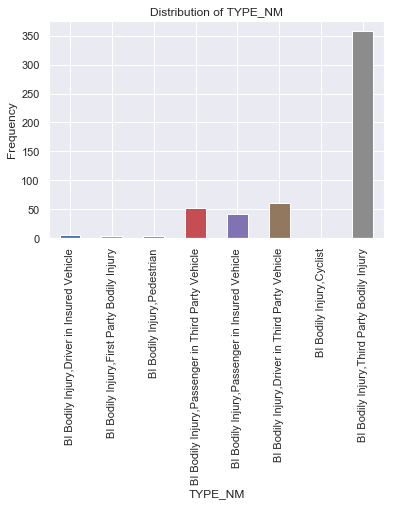

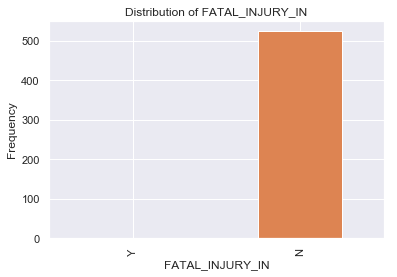

Unable to plot column HAS_INJURY_DETAILS


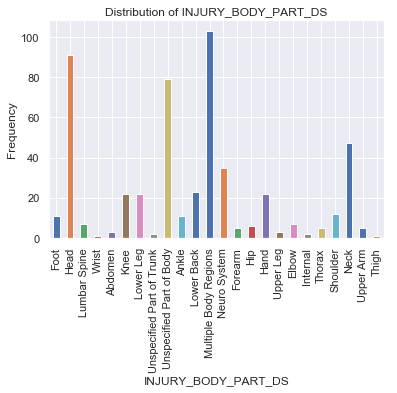

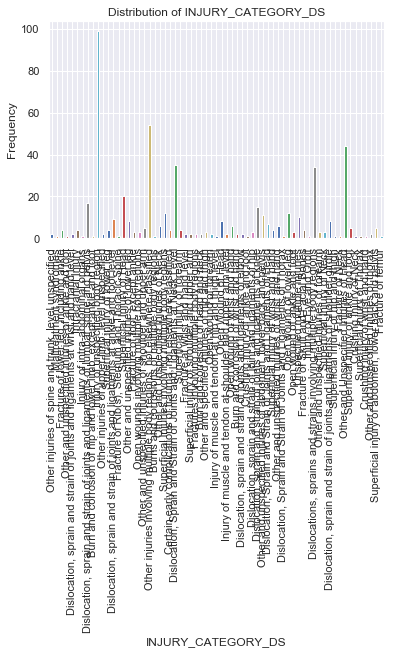

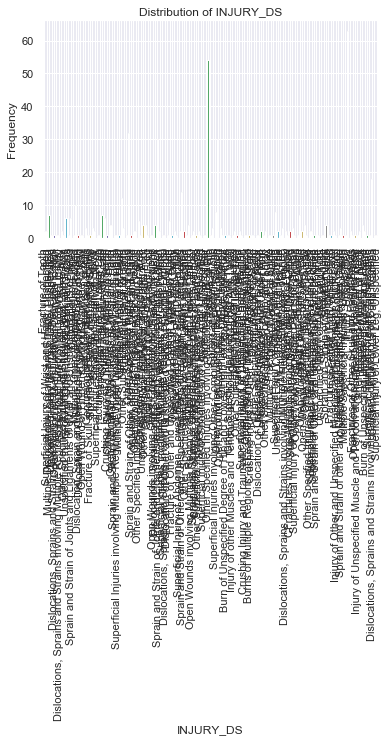

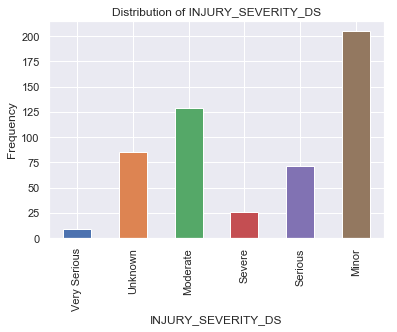

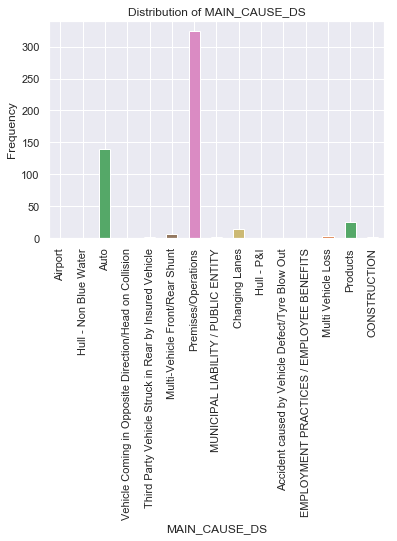

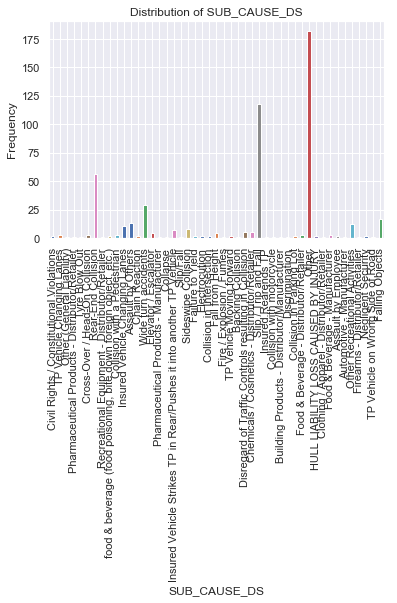

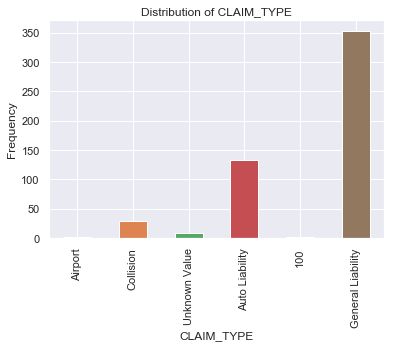

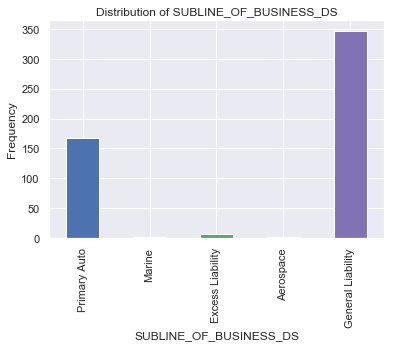

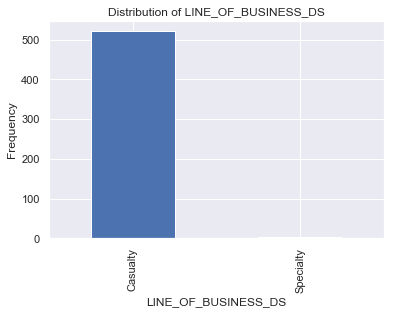

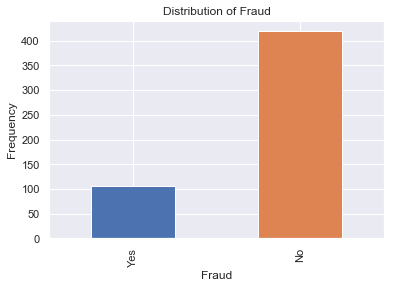

In [12]:
plot_univariate(df.drop(columns=['INDEMNITY_PAID_TO_DATE_USD_AM','EXPENSE_PAID_TO_DATE_USD','INSURED_NM','SUBLINE_OF_BUSINESS_CD','LINE_OF_BUSINESS_CD','Duration_of_claim_after_policy_effective','Duration_left_to_policy_expiry']))

##### Since we have categorical columns, we need to convert that into numeric columns in order to feed it to the model. Hence we use sklearn's lable encoder for this

In [13]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                if output[colname].dtype == 'object':
                    print("Encoding "+colname)
                    output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
encoding_pipeline = Pipeline([
('encoding',MultiColumnLabelEncoder())
# add more pipeline steps as needed
])
labeled_df = encoding_pipeline.fit_transform(df)
labeled_df

Encoding TYPE_NM
Encoding FATAL_INJURY_IN
Encoding INJURY_BODY_PART_DS
Encoding INJURY_CATEGORY_DS
Encoding INJURY_DS
Encoding INJURY_SEVERITY_DS
Encoding MAIN_CAUSE_DS
Encoding SUB_CAUSE_DS
Encoding INSURED_NM
Encoding CLAIM_TYPE
Encoding SUBLINE_OF_BUSINESS_DS
Encoding LINE_OF_BUSINESS_DS
Encoding Fraud


,INDEMNITY_PAID_TO_DATE_USD_AM,EXPENSE_PAID_TO_DATE_USD,TYPE_NM,FATAL_INJURY_IN,HAS_INJURY_DETAILS,INJURY_BODY_PART_DS,INJURY_CATEGORY_DS,INJURY_DS,INJURY_SEVERITY_DS,MAIN_CAUSE_DS,SUB_CAUSE_DS,INSURED_NM,CLAIM_TYPE,SUBLINE_OF_BUSINESS_DS,SUBLINE_OF_BUSINESS_CD,LINE_OF_BUSINESS_CD,LINE_OF_BUSINESS_DS,Fraud,Duration_of_claim_after_policy_effective,Duration_left_to_policy_expiry
0,0.00,1355.00,7,0,True,13,50,75,1,11,39,91,4,2,8,8,0,0,276,89
1,0.00,4400.00,7,0,True,16,17,106,0,11,39,208,4,2,8,8,0,1,215,150
2,0.00,4400.00,7,0,True,13,50,75,0,11,39,208,4,2,8,8,0,1,215,150
3,0.00,0.00,7,0,True,11,46,133,0,11,39,179,4,2,8,8,0,0,202,163
4,0.00,0.00,7,0,True,13,50,75,4,11,39,207,4,2,8,8,0,0,46,319
5,0.00,342.00,7,0,True,5,63,11,0,11,21,91,4,2,8,8,0,0,259,106
6,0.00,2171.00,7,0,True,13,18,25,1,11,39,70,4,2,8,8,0,1,119,246
7,0.00,0.00,7,0,True,13,50,75,2,11,32,191,4,1,9,8,0,0,323,42
8,0.00,342.00,7,0,True,19,31,44,4,11,18,91,4,2,8,8,0,0,323,42
9,0.00,0.00,7,0,True,9,37,56,0,11,18,91,4,2,8,8,0,0,5,360


##### Features Correlation

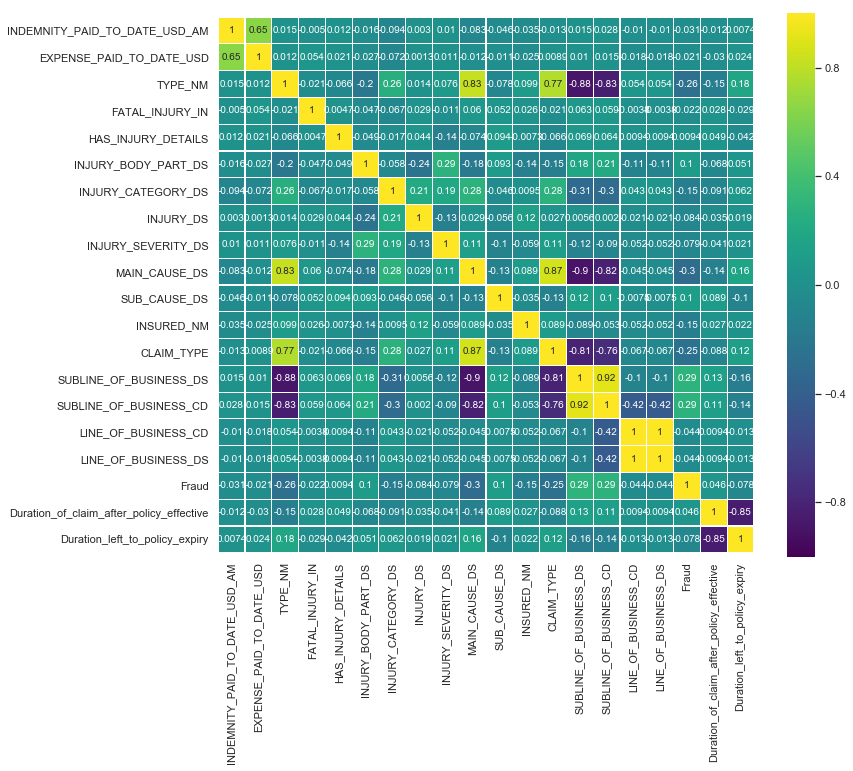

In [14]:
corr = labeled_df.corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 10}, square=True);

##### Separating features and target

In [15]:
features_labeled = labeled_df.drop(columns = ["Fraud"])
target_labeled = labeled_df[["Fraud"]]

##### Feature selection

In [16]:
#Considering he labeled set of features 
X, y = features_labeled,target_labeled["Fraud"]
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select = 5, step=1)
selector = selector.fit(X, y)
selector.support_

array([False, False, False,  True,  True, False, False, False, False,
       False, False, False,  True, False,  True,  True, False, False,
       False])

In [17]:
print("Top 5 features for Linear regression:-")
print(",".join(list(features_labeled.columns[selector.support_])))
print("\nFeature reanking:-")
print("\n".join([str((x,y)) for x,y in zip(features_labeled.columns,selector.ranking_)]))

Top 5 features for Linear regression:-
FATAL_INJURY_IN,HAS_INJURY_DETAILS,CLAIM_TYPE,SUBLINE_OF_BUSINESS_CD,LINE_OF_BUSINESS_CD

Feature reanking:-
('INDEMNITY_PAID_TO_DATE_USD_AM', 15)
('EXPENSE_PAID_TO_DATE_USD', 14)
('TYPE_NM', 5)
('FATAL_INJURY_IN', 1)
('HAS_INJURY_DETAILS', 1)
('INJURY_BODY_PART_DS', 6)
('INJURY_CATEGORY_DS', 8)
('INJURY_DS', 11)
('INJURY_SEVERITY_DS', 3)
('MAIN_CAUSE_DS', 2)
('SUB_CAUSE_DS', 7)
('INSURED_NM', 10)
('CLAIM_TYPE', 1)
('SUBLINE_OF_BUSINESS_DS', 9)
('SUBLINE_OF_BUSINESS_CD', 1)
('LINE_OF_BUSINESS_CD', 1)
('LINE_OF_BUSINESS_DS', 4)
('Duration_of_claim_after_policy_effective', 13)
('Duration_left_to_policy_expiry', 12)


##### splitting train and test data

In [18]:
 X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state =0)

### MODEL SELECTION
##### Creating pipeline for model selection

In [80]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
sgdc =  SGDClassifier()
mlpc =  MLPClassifier()
svc = SVC()
knnc = neighbors.KNeighborsClassifier()

model_list = []
model_list.append(('LR',lr))
model_list.append(('DTC',dtc))
model_list.append(('RFC',rfc))
model_list.append(('ABC',abc))
model_list.append(('GBC',gbc))
model_list.append(('SGDC',sgdc))
model_list.append(('MLPC',mlpc))
model_list.append(('SVC',svc))
model_list.append(('KNNC',knnc))

# modelname = []
# modelaccuracy = []
# model_roc_auc_score = []
final_list = []

for model_name,select_model in model_list:
    fit_model = select_model.fit(X_train,y_train)
    model_predict = fit_model.predict(X_test.values)
    model_accuracy = accuracy_score(y_test,model_predict)
    roc_auc_score_model = roc_auc_score(y_test,model_predict)
    final_list.append([model_name, model_accuracy, roc_auc_score_model])

cols = ['model_name', 'model_accuracy', 'roc_auc_score_model']
df1 = pd.DataFrame(final_list, columns=cols)
df1

C:\Users\sumitsuman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


,model_name,model_accuracy,roc_auc_score_model
0,LR,0.791139,0.580829
1,DTC,0.816456,0.773452
2,RFC,0.829114,0.683743
3,ABC,0.778481,0.611794
4,GBC,0.835443,0.717213
5,SGDC,0.772152,0.500000
6,MLPC,0.702532,0.611566
7,SVC,0.797468,0.555556
8,KNNC,0.803797,0.647769


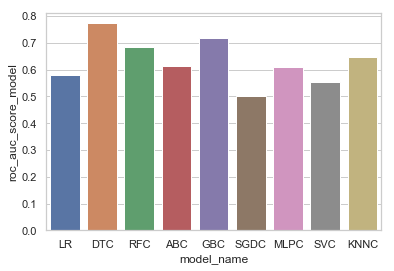

In [175]:
sns.set(style="whitegrid")
ax = sns.barplot(x="model_name", y="roc_auc_score_model", data=df1)

### MODEL TUNING & BUILDING

##### Logistic Regression Classifier

In [129]:
param_grid = {'penalty':['l2'], 'C':[0.001,0.01,0.1,1,10,11,16,100]}
grid = GridSearchCV(LogisticRegression(random_state=0),param_grid=param_grid,cv=5,refit = True)
grid.fit(X_train,y_train)
grid.best_params_

{'C': 100, 'penalty': 'l2'}

##### Random Forest Classifier

In [86]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [30, 40, 50, 60],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [1000, 1200, 1600, 2000]
}
gridsearch_tunning = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1)
gridsearch_tunning.fit(X_train,y_train)
gridsearch_tunning.best_params_

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2000}

##### AdaBoost Classifier

In [128]:
param_grid = {
    'n_estimators': [5,10],
    'learning_rate': [0.01,0.1,1]
}
gridsearch_tunning = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, cv=3, n_jobs=-1)
gridsearch_tunning.fit(X_train,y_train)
gridsearch_tunning.best_params_

{'learning_rate': 0.1, 'n_estimators': 5}

##### DecisionTree Classifier

In [92]:
max_depth = [int(x) for x in np.linspace(start=1, stop=32)]
max_features = list(range(1,labeled_df.shape[1]))
min_samples_leaf = [1,2,3,4]
min_samples_split = [2,5,10]
param_grid_data = {
    'max_depth':max_depth,
    'max_features':max_features,
    'min_samples_leaf':min_samples_leaf,
    'min_samples_split':min_samples_split
}
gridsearch_tunning = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid_data, cv=3, n_jobs=-1)
gridsearch_tunning.fit(X_train,y_train)
gridsearch_tunning.best_params_

{'max_depth': 3,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

##### Gradient Boosting Classifier

In [111]:
param_grid = {
    'max_depth':range(5,16,2),
    'max_features':range(7,20,2),
    'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]
}
gridsearch_tunning = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=3, n_jobs=-1)
gridsearch_tunning.fit(X_train,y_train)
gridsearch_tunning.best_params_

{'max_depth': 9, 'max_features': 7, 'subsample': 0.8}

##### model building

In [168]:
dtc = DecisionTreeClassifier(max_depth=3,max_features=4,min_samples_leaf=2,min_samples_split=5,random_state=0)
rfc = RandomForestClassifier(n_estimators=2000, max_depth=30, max_features=3, bootstrap=False, min_samples_leaf=1, min_samples_split=2,random_state=0)
lr = LogisticRegression(penalty = 'l2', C =100)
gbc = GradientBoostingClassifier(max_depth=9,max_features=7,subsample=0.8,random_state=0)

model_list = []
model_list.append(('DTC',dtc))
model_list.append(('RFC',rfc))
model_list.append(('LRC',lr))
model_list.append(('GBC',gbc))

final_list = []

for model_name,select_model in model_list:
    fit_model = select_model.fit(X_train,y_train)
    model_predict = fit_model.predict(X_test.values)
    model_accuracy = accuracy_score(y_test,model_predict)
    roc_auc_score_model = roc_auc_score(y_test,model_predict)
    final_list.append([model_name, model_accuracy, roc_auc_score_model])

cols = ['model_name', 'model_accuracy', 'roc_auc_score_model']
df2 = pd.DataFrame(final_list, columns=cols)
df2

,model_name,model_accuracy,roc_auc_score_model
0,DTC,0.772152,0.597905
1,RFC,0.854430,0.729508
2,LRC,0.778481,0.562842
3,GBC,0.848101,0.735200


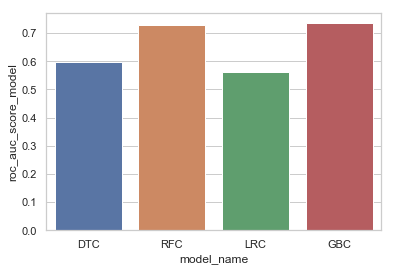

In [174]:
sns.set(style="whitegrid")
ax = sns.barplot(x="model_name", y="roc_auc_score_model", data=df2)

### MODEL EVALUATION

##### Confusion Matrix

In [138]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')
        
      #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

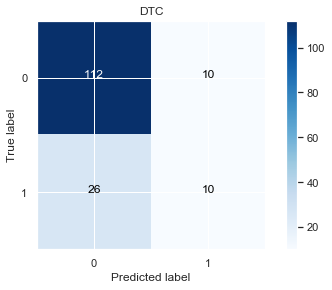

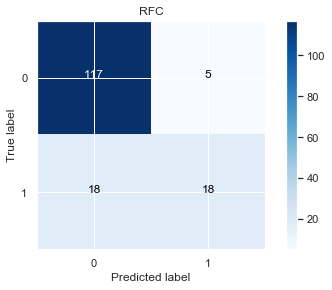

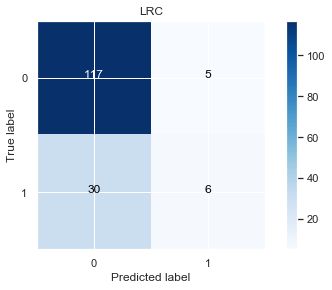

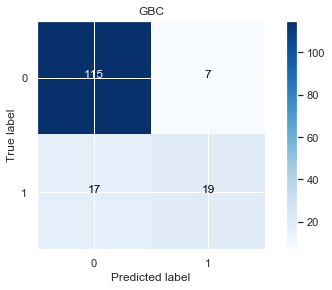

In [156]:
for model_name,select_model in model_list:
    fit_model = select_model.fit(X_train,y_train)
    model_predict = fit_model.predict(X_test)
    cnf_matrix = confusion_matrix(y_test,model_predict)
    np.set_printoptions(precision=2)
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix, classes=class_names,title=model_name)    
    plt.show()

##### ROC curve

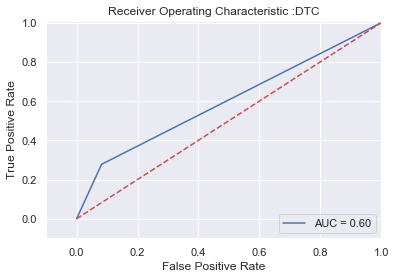

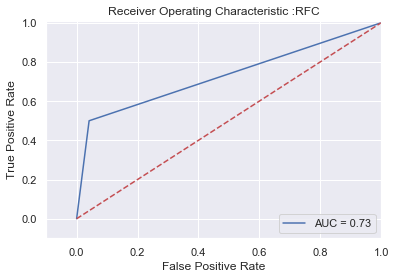

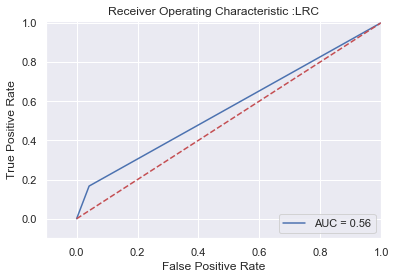

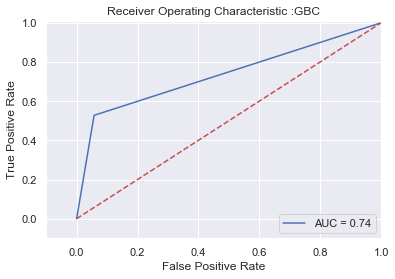

In [173]:
for model_name,select_model in model_list:
    fit_model = select_model.fit(X_train,y_train)
    model_predict = fit_model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,model_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title("Receiver Operating Characteristic :"+model_name)
    plt.plot(false_positive_rate, true_positive_rate, 'b' ,label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()